# Classification analysis of a Thyroid Disease Data Set


## Data

**Main link:**

http://archive.ics.uci.edu/ml/datasets/thyroid+disease


**Data Set Information:**

          General Description of Thyroid Disease Databases
                        and Related Files

This directory contains 6 databases, corresponding test set, and
corresponding documentation.  They were left at the University of
California at Irvine by Ross Quinlan during his visit in 1987 for
the 1987 Machine Learning Workshop.  

The documentation files (with file extension "names") are formatted to
be read by Quinlan's C4 decision tree program.  Though briefer than
the other documentation files found in this database repository, they
should suffice to describe the database, specifically:

    1. Source
    2. Number and names of attributes (including class names)
    3. Types of values that each attribute takes

In general, these databases are quite similar and can be characterized
somewhat as follows:

    1. Many attributes (29 or so, mostly the same set over all the databases) mostly numeric or Boolean valued attributes
    3. thyroid disease domains (records provided by the Garavan Institute
       of Sydney, Australia)
    4. several missing attribute values (signified by "?")
    5. small number of classes (under 10, changes with each database)
    7. 2800 instances in each data set
    8. 972 instances in each test set (It seems that the test sets' instances
       are disjoint with respect to the corresponding data sets, but this has
       not been verified)

As we can see below, some changes were maid in the original dataset - test and train data was joined together.

**Independent Variables:**

There is no information provided about individual variables

**Target variable:**

* `Class`

## EDA

### Imports

Let's import the dataset, replace '?' with proper np.NaN, and see its overall structure

In [ ]:
%matplotlib inline

!pip3 install --upgrade pip
!pip3 install --upgrade all

import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.graphics.mosaicplot import mosaic

import missingno as msno
!pip install robustats
import robustats
from pathlib import Path

#from pandas_profiling import ProfileReport
from sklearn.model_selection import GridSearchCV, cross_validate, \
  KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, \
  recall_score, f1_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from scipy import stats

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement all (from versions: none)
ERROR: No matching distribution found for all
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Myoth13/datasets/main/dataset_57_hypothyroid.csv')
df.replace(to_replace=['?'], value=np.NaN, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   object 
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

We can see:


1.   There are one totally empty column: `TBG` and some missing data in others
2.    Violation of the data type constrains - all columns are represented as strings



Let's begin by dropping an empty column

In [ ]:
df.drop(['TBG'], axis=1, inplace=True)

### Data type constrains

Let's see what's inside of the dataset

In [ ]:
pd.set_option('display.max_columns', None)
display(df.loc[100:110,:])

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,Class
100,28,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,1.4,t,120,t,0.82,t,146,f,SVI,negative
101,62,M,f,f,f,t,f,f,f,f,f,f,f,f,f,f,t,12,t,1.5,t,105,t,0.86,t,122,f,other,compensated_hypothyroid
102,31,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.4,t,2.3,t,150,t,1.42,t,106,f,SVHC,negative
103,71,F,t,f,f,f,f,f,f,f,t,f,f,f,f,f,t,0.5,f,NaN,t,126,t,1.02,t,124,f,other,negative
104,57,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
105,78,M,f,f,f,t,f,f,f,f,f,f,f,f,f,f,t,2.1,t,1.8,t,80,t,0.72,t,111,f,other,negative
106,58,NaN,t,f,f,f,f,f,f,f,t,f,f,f,f,f,t,0.01,t,3.3,t,129,t,1.23,t,105,f,SVI,negative
107,18,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,t,2.4,t,86,t,1.01,t,85,f,other,negative
108,59,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,3.1,t,110,t,1.06,t,104,f,SVI,negative
109,77,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.6,t,1.2,t,146,t,0.93,t,157,f,SVI,negative


We can see that
1) `X_measured` and `X` are basically the dublication, and I would drop them straight away, but let's keep it for a while, because last time I got a problem bc of droping variables =))
2) all fields either categorical or numerical. Let's make a list of numerical features and all other columns of the categorical type::

In [ ]:
num_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
df[num_cols] = df[num_cols].astype('float')
cat_cols = df.select_dtypes(object).columns.tolist()
df[cat_cols] = df[cat_cols].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        3771 non-null   float64 
 1   sex                        3622 non-null   category
 2   on_thyroxine               3772 non-null   category
 3   query_on_thyroxine         3772 non-null   category
 4   on_antithyroid_medication  3772 non-null   category
 5   sick                       3772 non-null   category
 6   pregnant                   3772 non-null   category
 7   thyroid_surgery            3772 non-null   category
 8   I131_treatment             3772 non-null   category
 9   query_hypothyroid          3772 non-null   category
 10  query_hyperthyroid         3772 non-null   category
 11  lithium                    3772 non-null   category
 12  goitre                     3772 non-null   category
 13  tumor                      3772 n

Now our datatypes looks alright. !Caution: I will not use scikit-learn's encoders on the target var, because it works just fine with native pandas category type.

### Uniqness constrains

Let's check for duplicate rows:

In [ ]:
df.duplicated().sum()

61

Let's drop them

In [ ]:
df.drop_duplicates(inplace=True)

### Missing data

Let's see overall amount of missing values

Text(0.5, 1.0, 'Percent of non-null values by variable')

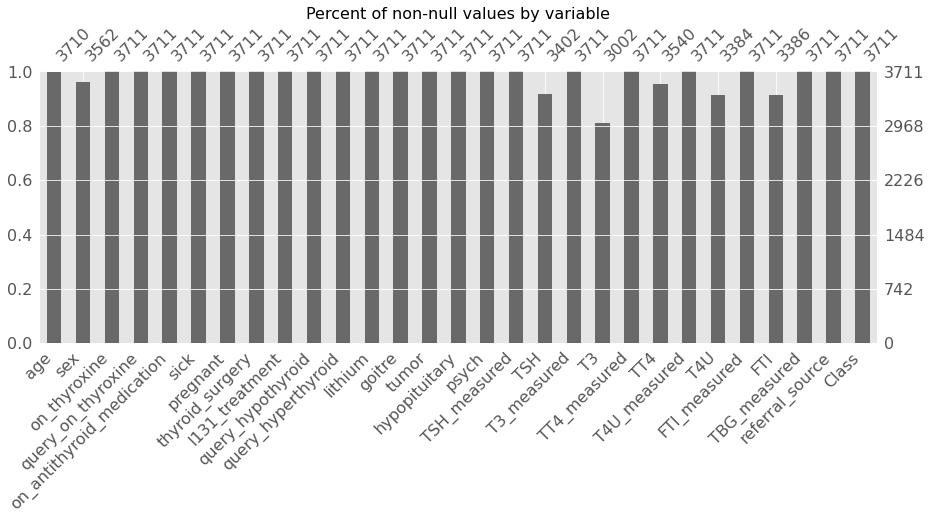

In [ ]:
msno.bar(df, figsize=(15, 5))
plt.title('Percent of non-null values by variable', fontsize=16)
plt.show()

We can see, that all columns has decent % of data available and it's fine to impute it.

Now let's see the pattern of missingness:

Text(0.5, 1.0, 'Missing values by variable')

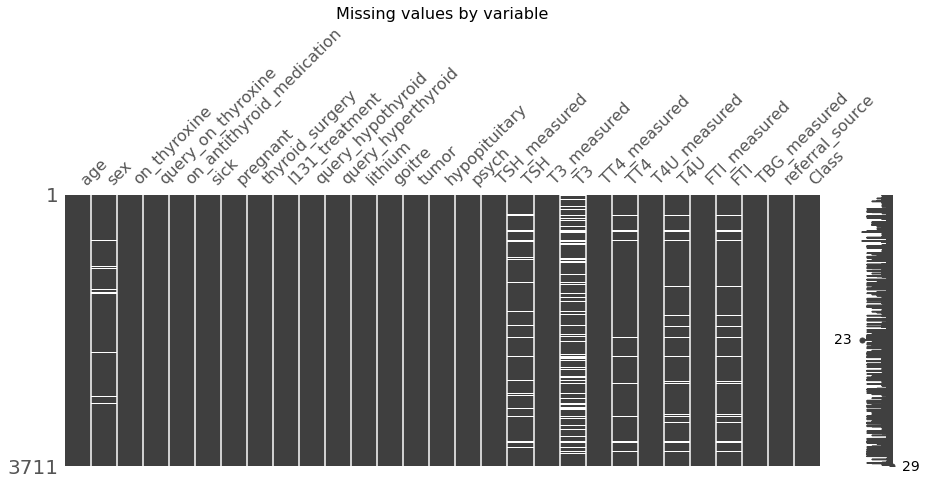

In [ ]:
df.sort_values('Class', inplace=True)
msno.matrix(df, figsize=(15, 5))
plt.title('Missing values by variable', fontsize=16)
plt.show()

We can see a very interesting pattern here:
* Missing data in the variables looks almost random (almost the same pattern can be seen across `TT4`, `T4U`, and `FTI`). I will impute it later in the pipeline.

### Useless data and constans

Let's check for useless fields:

In [ ]:
(df.nunique()/len(df)).sort_values(ascending=False)

TSH                          0.077338
TT4                          0.064942
FTI                          0.063056
T4U                          0.039342
age                          0.025061
T3                           0.018593
referral_source              0.001347
Class                        0.001078
I131_treatment               0.000539
query_hypothyroid            0.000539
on_thyroxine                 0.000539
query_on_thyroxine           0.000539
FTI_measured                 0.000539
on_antithyroid_medication    0.000539
T4U_measured                 0.000539
sick                         0.000539
TT4_measured                 0.000539
pregnant                     0.000539
T3_measured                  0.000539
thyroid_surgery              0.000539
TSH_measured                 0.000539
psych                        0.000539
sex                          0.000539
tumor                        0.000539
goitre                       0.000539
lithium                      0.000539
query_hypert

There are no columns with all unique values.

Let's check for constants - fields with zero variance among numerical columns:

In [ ]:
df.var().sort_values(ascending=True)

T4U       0.038214
T3        0.684875
age     404.958661
TSH     601.475529
FTI    1094.836671
TT4    1267.725411
dtype: float64

We can see here that we don't have zero variance fields which means we don't have constans. Let's check categorical columns.

In [ ]:
df[cat_cols].nunique()

sex                          2
on_thyroxine                 2
query_on_thyroxine           2
on_antithyroid_medication    2
sick                         2
pregnant                     2
thyroid_surgery              2
I131_treatment               2
query_hypothyroid            2
query_hyperthyroid           2
lithium                      2
goitre                       2
tumor                        2
hypopituitary                2
psych                        2
TSH_measured                 2
T3_measured                  2
TT4_measured                 2
T4U_measured                 2
FTI_measured                 2
TBG_measured                 1
referral_source              5
Class                        4
dtype: int64

We can see here, that `TBG_measured` is constant and we can drop it

In [ ]:
df.drop('TBG_measured', axis=1, inplace=True)
cat_cols.remove('TBG_measured')

### Data range constrains

Let's see the overall statistics over numerical variables:

In [ ]:
df[num_cols].describe()

,age,TSH,T3,TT4,T4U,FTI
count,3710.000000,3402.000000,3002.000000,3540.000000,3384.000000,3386.000000
mean,51.860377,5.087820,2.013504,108.328475,0.994989,110.480715
std,20.123585,24.524998,0.827572,35.605132,0.195485,33.088316
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000


We can see here that:
* `age` for sure has some mistakes bc max value of 455 is unrealistic
* `TSH` of 530 is also too high value
Let's see levels of categorical variables

In [ ]:
df.drop(df[df.age > 100].index, inplace = True)

In [ ]:
df[cat_cols].describe()

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,referral_source,Class
count,3561,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710,3710
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,4
top,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,t,t,t,t,other,negative
freq,2423,3246,3660,3668,3563,3657,3657,3651,3476,3476,3692,3676,3614,3709,3526,3401,3001,3539,3383,3385,2140,3419


Levels look alright

### Target variable

Let's look at the distribution of the target variable:

In [ ]:
df['Class'].value_counts()
fig = px.histogram(
    data_frame=df,
    x='Class',
    title='Distribution of the target variable',
#    nbins=20,
    width = 600,
    height = 500
    )
fig.show()

negative                   3419
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

We can see that our target variable is highly imbalanced, whith only two observations of `secondary_hypothyroid` level. No oversampling technique can help with such a small number of observations, so I will combine secondary and primary into one level and try multicalss with only three classes.

In [ ]:
df['Class'].replace(['secondary_hypothyroid','primary_hypothyroid'], 'sec_or_pr_hypothyroid', inplace=True)

### Independent variables

#### Distribution and dependences

Text(0.5, 0.98, 'Distribution of the numeric variables')

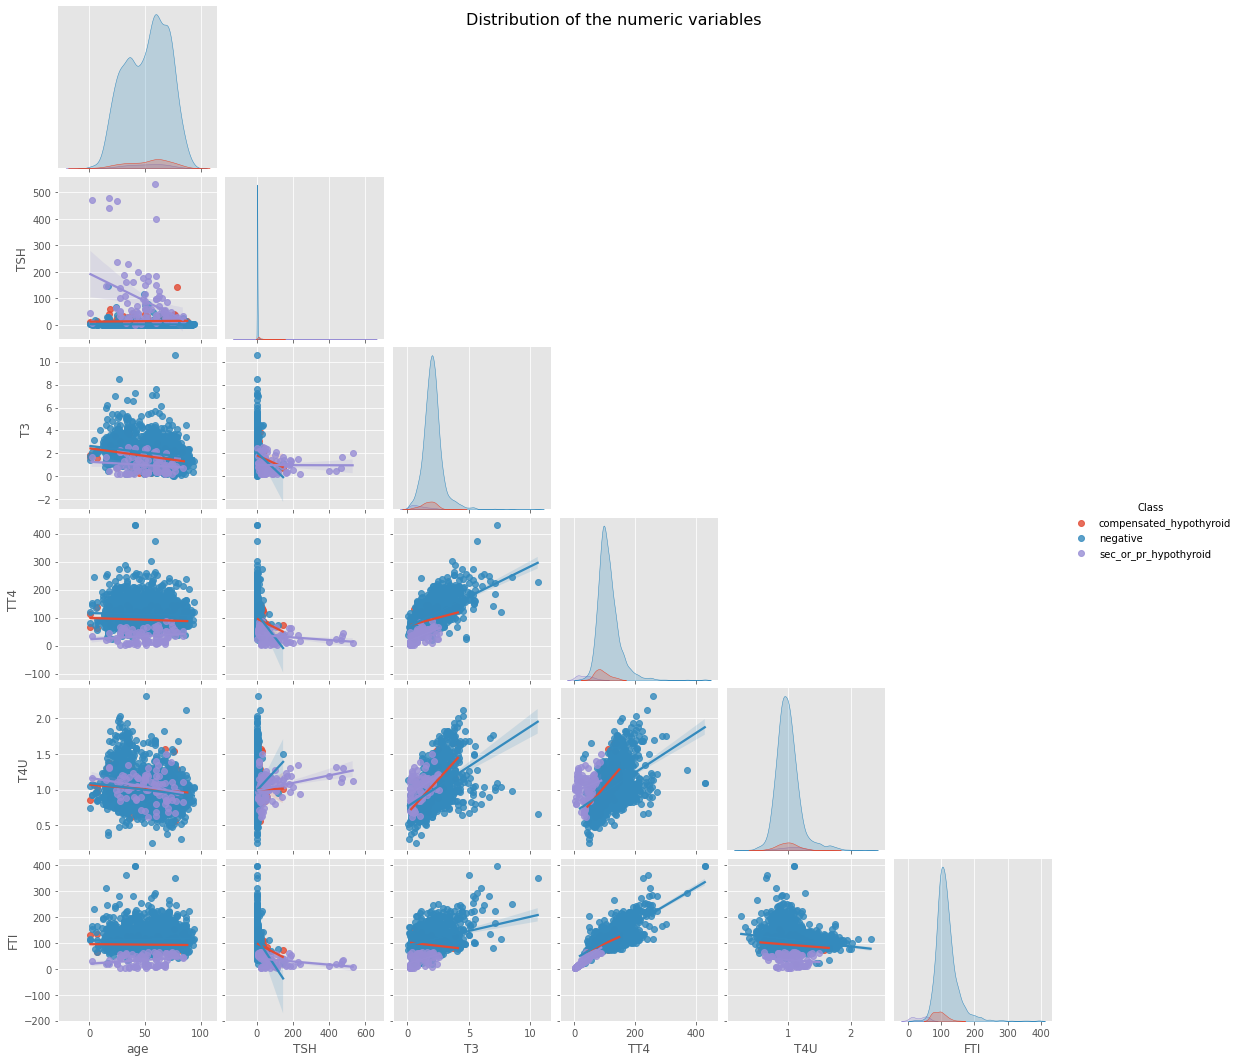

In [ ]:
sns.pairplot(df, corner=True, kind="reg", hue='Class')
plt.suptitle('Distribution of the numeric variables', fontsize=16)
plt.show()

We can see here:
* All features have distributions with outliers that I will try to deal later. I will not use transformations here, because otherwise form of the distribution is alright.

#### Correlations

Let's look at the correlations between variables. I will use original dataset, o I will use spearmans correlation coefficient instead of Pearsons because of the non-linearity

Text(0.5, 1.0, 'Spearmans corr')

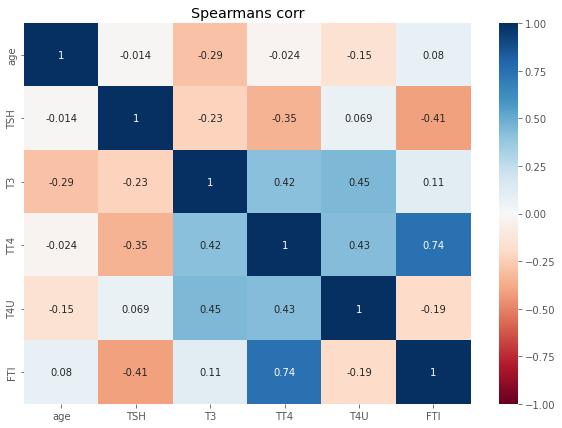

In [ ]:
corr_table = df.corr(method='spearman')
sns.heatmap(corr_table, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Spearmans corr')
plt.show()

We can see here:

* Among numeric variables there aren't very strong correlations (close to 1). Let's see the distribution of numerical vars by target  

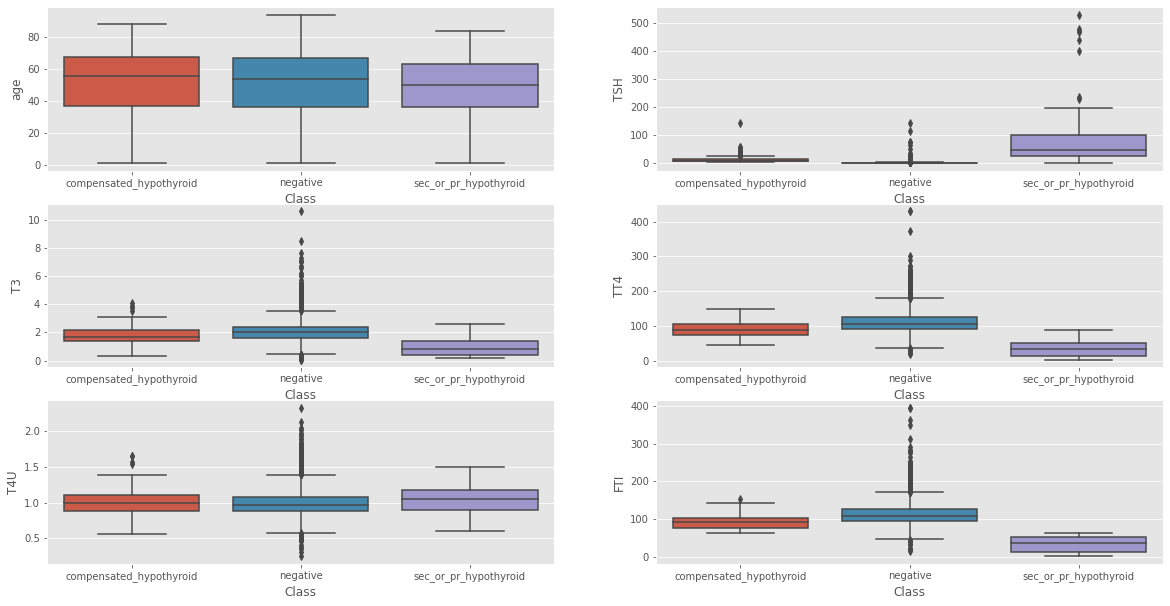

In [ ]:
max_shape = np.ceil(df.shape[1] / 2)
fig = plt.figure(figsize=(20,50))
for i, col in enumerate(num_cols):
    plt.subplot(max_shape, 2, i+1)
    _ = sns.boxplot(x = 'Class', y = col, data = df)
plt.show()

we can see here, that almost all numerical features has different means and distributions, which indicate their importance for the model

#### Categorical variables

In [ ]:
    for col in cat_cols:
        print(df[col].value_counts())

F    2423
M    1138
Name: sex, dtype: int64
f    3246
t     464
Name: on_thyroxine, dtype: int64
f    3660
t      50
Name: query_on_thyroxine, dtype: int64
f    3668
t      42
Name: on_antithyroid_medication, dtype: int64
f    3563
t     147
Name: sick, dtype: int64
f    3657
t      53
Name: pregnant, dtype: int64
f    3657
t      53
Name: thyroid_surgery, dtype: int64
f    3651
t      59
Name: I131_treatment, dtype: int64
f    3476
t     234
Name: query_hypothyroid, dtype: int64
f    3476
t     234
Name: query_hyperthyroid, dtype: int64
f    3692
t      18
Name: lithium, dtype: int64
f    3676
t      34
Name: goitre, dtype: int64
f    3614
t      96
Name: tumor, dtype: int64
f    3709
t       1
Name: hypopituitary, dtype: int64
f    3526
t     184
Name: psych, dtype: int64
t    3401
f     309
Name: TSH_measured, dtype: int64
t    3001
f     709
Name: T3_measured, dtype: int64
t    3539
f     171
Name: TT4_measured, dtype: int64
t    3383
f     327
Name: T4U_measured, dtype: int64
t   

We can see that:
* `tumor` column has only one positive value, because of this it is useless and I will drop it.

In [ ]:
cat_cols.remove('tumor')
df.drop('tumor', axis=1, inplace=True)

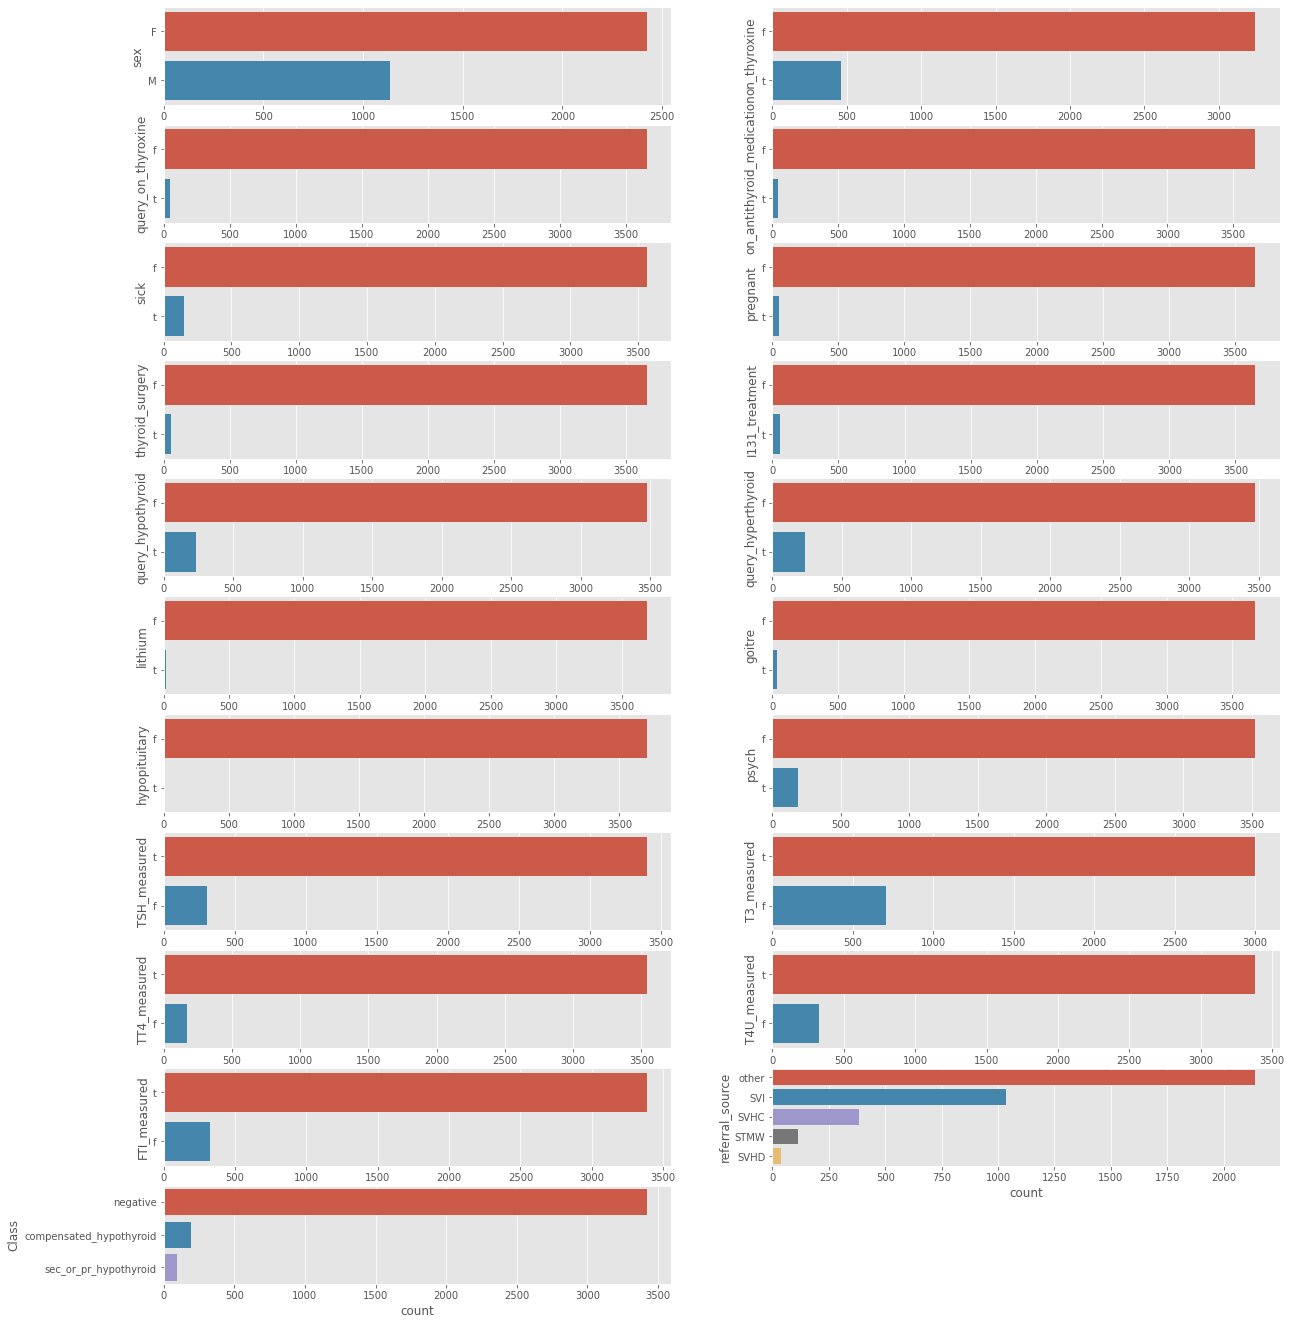

In [ ]:
    max_shape = np.ceil(df.shape[1] / 2)
    fig = plt.figure(figsize=(20,30))
    for i, col in enumerate(cat_cols):
        plt.subplot(max_shape, 2, i+1)
        _ = sns.countplot(y = col, data = df, order=df[col].value_counts().index)
    plt.show()

We can see that many features are imbalanced as well, so we have to deal with it during encoding.

## PCA

### Splitting into test and train datasets

Because our dataset has time component, I will use `TimeSeriesSplit`

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

y = df['Class']
X = df.drop(['Class'], axis=1)
cat_cols.remove('Class')

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

### Preprocessor pipeline

I'm using `MinMaxScaler`  because of outliers. As the more robust technique I'm using median strategy for imputing the missing values for munerical and KNN imputer for categorical

In [ ]:
print('Shape before the transformation:')
print(X_train.shape)
print(X_test.shape)

num_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='median')),
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('imputer', KNNImputer()),
])

preprocessor = ColumnTransformer(
    transformers=[
      ('num', num_pipeline, num_cols),
      ('cat', cat_pipeline, cat_cols),

])

pipeline = make_pipeline(
    preprocessor,
    PCA(n_components=0.99),
)


X_train_tr = pipeline.fit_transform(X_train)
X_test_tr = pipeline.transform(X_test)

print('Shape after the transformation:')
print(X_train_tr.shape)
print(X_test_tr.shape)

Shape before the transformation:
(2782, 26)
(928, 26)
Shape after the transformation:
(2782, 23)
(928, 23)


### Principal components

Text(0.5, 1.0, 'Scree Plot')

Text(0.5, 0, 'Principal Component')

Text(0, 0.5, 'Variance Explained')

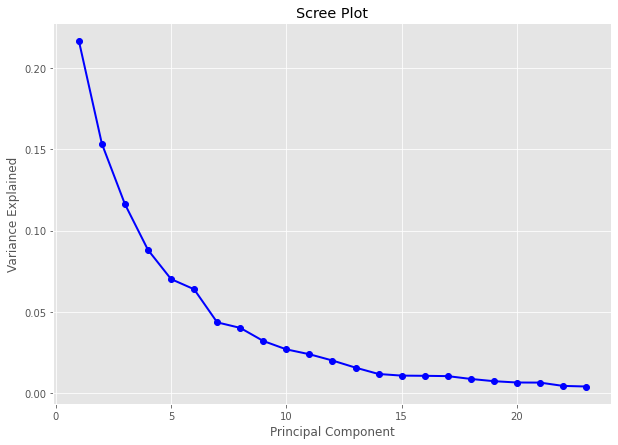

In [ ]:
PCA_values = np.arange(pipeline['pca'].n_components_) + 1
plt.plot(PCA_values, pipeline['pca'].explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

We can see here that despite one hot encoding we still good with 22 components (99% variance captured)

## Modelling

### Model evaluation function

For my model evaluation I've chosen recall, because we are classifying a rare disease and false negatives are very dangerous.

In [ ]:
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, cv):

  scorers = {
              'f1_score': make_scorer(f1_score, average='micro'),
              'precision_score': make_scorer(precision_score, average='micro'),
              'recall_score': make_scorer(recall_score, average='micro'),
              'accuracy_score': make_scorer(accuracy_score)
            }

  results = cross_validate(estimator=pipeline, X=X_train, y=y_train, cv=cv, scoring=scorers, return_train_score=True, error_score="raise")

  ppl = pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)

  #print(results)

  train_score = results['train_recall_score']
  val_score = results['test_recall_score']

  print(f'\nTrain recall: {train_score.mean():.3f}, Std: {train_score.std():.3f}')
  print(f'Validation recall: {val_score.mean():.3f}, Std: {val_score.std():.3f}')
  print(f'Test recall: {pipeline.score(X_test, y_test):.3f}')

  print(classification_report(y_test, y_pred))

  return pipeline

### Baseline model

Let's make a baseline model

In [ ]:
base_model = LogisticRegression()

base_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', base_model)
])

evaluate_model(clone(base_pipeline), X_train, y_train, X_test, y_test, cv)



Train recall: 0.935, Std: 0.001
Validation recall: 0.933, Std: 0.010
Test recall: 0.931
                         precision    recall  f1-score   support

compensated_hypothyroid       0.00      0.00      0.00        49
               negative       0.93      1.00      0.96       855
  sec_or_pr_hypothyroid       1.00      0.38      0.55        24

               accuracy                           0.93       928
              macro avg       0.64      0.46      0.50       928
           weighted avg       0.88      0.93      0.90       928



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'TSH', 'T3', 'TT4',
                                                   'T4U', 'FTI']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('imputer',
      

We can see that on minority class performance is very poor. Let's try to choose some parameters for the LogisticRegression

### LogisticRegression Model

For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;

The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:
* ‘lbfgs’ - [‘l2’, None]
* ‘newton-cg’ - [‘l2’, None]
* ‘sag’ - [‘l2’, None]
* ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]

C - Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.



In [ ]:
grid = {
    'model__penalty' : ['none', 'l2'],
    'model__C'       : np.logspace(-3, 3, 7),
    'model__solver'  : ['newton-cg', 'lbfgs', 'sag', 'saga'],
}

gs = GridSearchCV(base_pipeline, grid,
                  n_jobs=-1,
                  scoring=['recall'],
                  refit='recall',
                  cv=cv)

tmp = gs.fit(X_train, y_train)

lr_pipeline = gs.best_estimator_

evaluate_model(clone(lr_pipeline), X_train, y_train, X_test, y_test, cv)


Train recall: 0.979, Std: 0.002
Validation recall: 0.971, Std: 0.009
Test recall: 0.966
                         precision    recall  f1-score   support

compensated_hypothyroid       0.87      0.53      0.66        49
               negative       0.97      1.00      0.98       855
  sec_or_pr_hypothyroid       0.86      0.79      0.83        24

               accuracy                           0.97       928
              macro avg       0.90      0.77      0.82       928
           weighted avg       0.96      0.97      0.96       928



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'TSH', 'T3', 'TT4',
                                                   'T4U', 'FTI']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('imputer',
      

I think this is drastically better. Let's see the model parameters which were chosen:

In [ ]:
print(lr_pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'TSH', 'T3', 'TT4',
                                                   'T4U', 'FTI']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('imputer',
      

Let's try to add SMOTE to this model:

### LogisticRegression + SMOTE

In [ ]:
smote_model = LogisticRegression(C=0.001, penalty='none',
                                    solver='newton-cg')

over = SMOTE(sampling_strategy={'compensated_hypothyroid': 2000, 'sec_or_pr_hypothyroid': 2000}, k_neighbors=2)

smote_pipeline = make_pipeline(
    preprocessor,
    over,
    smote_model,
)

tmp = evaluate_model(clone(smote_pipeline), X_train, y_train, X_test, y_test, cv)




Train recall: 0.986, Std: 0.001
Validation recall: 0.975, Std: 0.010
Test recall: 0.980
                         precision    recall  f1-score   support

compensated_hypothyroid       0.86      0.90      0.88        49
               negative       0.99      0.99      0.99       855
  sec_or_pr_hypothyroid       0.79      0.79      0.79        24

               accuracy                           0.98       928
              macro avg       0.88      0.89      0.89       928
           weighted avg       0.98      0.98      0.98       928



I think this is a good result. Let's see feature importances

### Feature importances

Let's see graphically first. Please help me get out feature names! I can't find a solution in googgle

In [1]:
#print(tmp)
index = tmp['columntransformer'].transformers_[1][1]\
    ['encoder'].get_feature_names(cat_cols)

ind = num_cols.copy()
ind.extend(index)
print(ind)

NameError: name 'tmp' is not defined

But I need transformed feature names =(

['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'sex_F', 'sex_M', 'sex_nan', 'on_thyroxine_f', 'on_thyroxine_t', 'query_on_thyroxine_f', 'query_on_thyroxine_t', 'on_antithyroid_medication_f', 'on_antithyroid_medication_t', 'sick_f', 'sick_t', 'pregnant_f', 'pregnant_t', 'thyroid_surgery_f', 'thyroid_surgery_t', 'I131_treatment_f', 'I131_treatment_t', 'query_hypothyroid_f', 'query_hypothyroid_t', 'query_hyperthyroid_f', 'query_hyperthyroid_t', 'lithium_f', 'lithium_t', 'goitre_f', 'goitre_t', 'hypopituitary_f', 'hypopituitary_t', 'psych_f', 'psych_t', 'TSH_measured_f', 'TSH_measured_t', 'T3_measured_f', 'T3_measured_t', 'TT4_measured_f', 'TT4_measured_t', 'T4U_measured_f', 'T4U_measured_t', 'FTI_measured_f', 'FTI_measured_t', 'referral_source_STMW', 'referral_source_SVHC', 'referral_source_SVHD', 'referral_source_SVI', 'referral_source_other']


Text(0.5, 1.0, 'Feature importances for the first class')

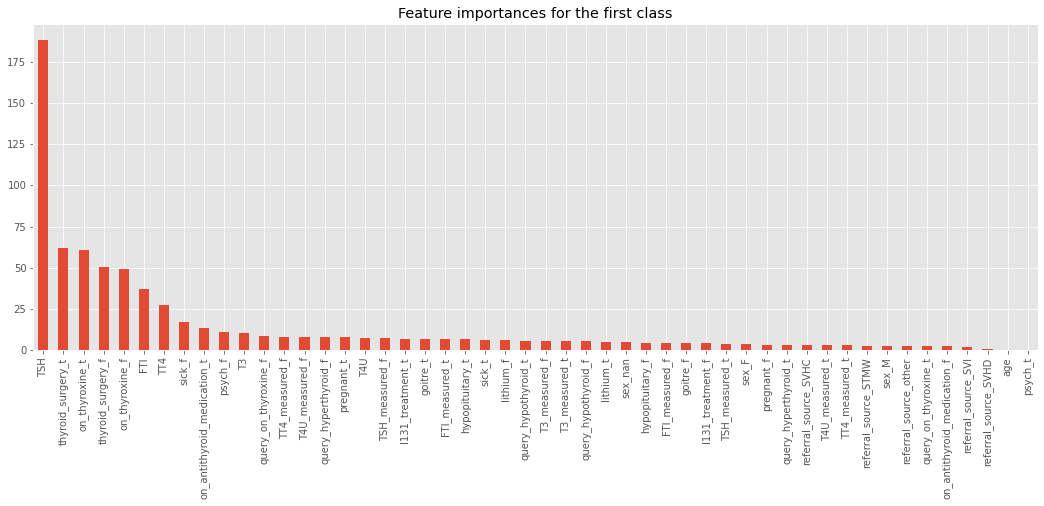

In [ ]:
feature_importance = pd.Series(index = ind,
                               data = np.abs(tmp.named_steps['logisticregression'].coef_[0]))

feature_importance.sort_values(ascending=False).plot(kind = 'bar', figsize = (18,6))
plt.title('Feature importances for the first class')

We can see that a lot of coefficients are not important for the model

### KNN Model

I would like to try DecisionTree because it is good with inbalanced data, but KNN is requred and I run out of time

In [ ]:
knn_model = KNeighborsClassifier()

knn_pipeline = make_pipeline(
    preprocessor,
    over,
    knn_model,
)


grid = {
  'kneighborsclassifier__n_neighbors': np.arange(10, 50),
  'kneighborsclassifier__weights': ('uniform', 'distance'),
  'kneighborsclassifier__metric': ('minkowski', 'chebyshev'),
}

gs = GridSearchCV(knn_pipeline, grid,
                  n_jobs=-1,
                  scoring=['recall'],
                  refit='recall',
                  cv=cv)

tmp = gs.fit(X_train, y_train)

knn_pipeline = gs.best_estimator_

evaluate_model(clone(knn_pipeline), X_train, y_train, X_test, y_test, cv)


Even with SMOTE oversampling it has shown much weaker performance than LogisticRegression - not a good choice for this particular dataset.